# Example of a simple transaction fiat->token economy

This is a super basic type of token economy, that will not often happen in practice. It assumes that all inflows are in fiat, and pricing happens through external forces. 

Then, these transactions are simply converted into a token equivalent. This presents the most basic case of a token economy.



In [1]:
import numpy as np
import scipy
import sys
sys.path.insert(0,'..')

from simulationcomponents import *
from simulationcomponents.usergrowthclasses import *
from simulationcomponents.transactionclasses import *
from simulationcomponents.tokeneconomyclasses import *
from simulationcomponents.transactionclasses import *
from simulationcomponents.agentpoolclasses import *
from simulationcomponents.pricingclasses import *
from simulationcomponents.addons import AddOn_RandomNoise, AddOn_RandomNoiseProportional
from utils.helpers import *
from matplotlib import pyplot as plt

# Globals

We start by defining our globals. We choose 60 iterations, with each iteration representing 1 month, and an average holding time of 1 month. The total circulating supply is 100 million

In [2]:
ITERATIONS=60
HOLDING_TIME=1
SUPPLY=10**10
INITIAL_PRICE=0.1

## Agent pools

TokenLab is based a modular logic. A token economy is composed of agent pools that can have various dependencies with each other.

The most basic agent pool contains a group of users who act independently from each other. This, for example, can be a group of consumers, who independently decide to buy a token in order to access a good or a service. 

Agent pools are using Controller objects for their inside parts.

The simplest type of agent pool is the AgentPool_Basic type. It assumes that there are only two Controller objects needed: one to simulate the number of users, and one to simulate the volume of transactions.

We can also simply provide a fixed number to each one of those parameters. This is a very simple case, where we assume we have a steady number of users, and that the total value of transactions at each unit of time is simply users *  transactions_controller


### Currency and agentpools

In this particular example, we are setting the currency to be in USD which is the default option for token economies. When creating an agent pool we can either denominate in USD or in the token. An AgentPool_Basic object is used to generate transactions. When these transactions are denominated in fiat, then the token economy will convert them internally into tokens, when calculating price and other parameters.

If the agent pool's currency was denominated in token, then it take the current price, and run calculations to understand the transaction volume.

It's usually easier to make assumptions for the demand of a token based on fiat, rather than a token. However, an agent pool with the token as a currency can be used when we are simulating pools like speculators of the token.

In [3]:
ap_fiat=AgentPool_Basic(users_controller=10000,transactions_controller=1000,currency='$')

# Token economy

Now, we define a token economy object. We then feed this object into the TokenMetaSimulator which allows to perform multiple experiments with a token economy. The parameter iterations refers to the internal iterations for each token economy run, and the parameter repetitions is the total number of simulations to perform. 

This simple token economy assumes an average holding time which is determined by the user. There is also the option to create adaptive holding times, calculated from the sim's parameters or stochastic ones, as we will explore later.

In [4]:
te=TokenEconomy_Basic(holding_time=HOLDING_TIME,supply=SUPPLY,token='tokenA',initial_price=INITIAL_PRICE)
te.add_agent_pools([ap_fiat])

True

In [5]:
meta=TokenMetaSimulator(te)
meta.execute(iterations=ITERATIONS,repetitions=50)
reps=meta.get_data()

100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 560.14it/s]


In [6]:
reps

,tokenA_price,transactions_$,num_users,iteration,holding_time,effective_holding_time,supply,transactions_tokenA,repetition_run,iteration_time
0,0.001,10000000,10000,1,1,1.0,10000000000,1.000000e+08,0,0
1,0.001,10000000,20000,2,1,1.0,10000000000,1.000000e+10,0,1
2,0.001,10000000,30000,3,1,1.0,10000000000,1.000000e+10,0,2
3,0.001,10000000,40000,4,1,1.0,10000000000,1.000000e+10,0,3
4,0.001,10000000,50000,5,1,1.0,10000000000,1.000000e+10,0,4
...,...,...,...,...,...,...,...,...,...,...
55,0.001,10000000,560000,56,1,1.0,10000000000,1.000000e+10,49,55
56,0.001,10000000,570000,57,1,1.0,10000000000,1.000000e+10,49,56
57,0.001,10000000,580000,58,1,1.0,10000000000,1.000000e+10,49,57
58,0.001,10000000,590000,59,1,1.0,10000000000,1.000000e+10,49,58


We can use the get_timeseries() method for any of the columns produced by the metasimulator, in order to get a graph averaged across all repetitions/runs. As you can see below the price is stable, which is what we expected, since we have a stable number of users and transaction value.

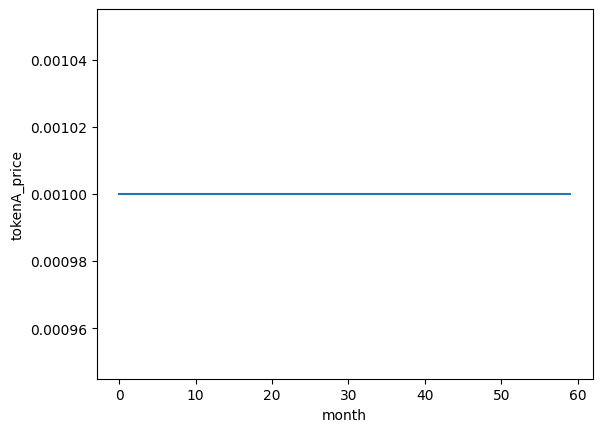

In [7]:
plot,data=meta.get_timeseries('tokenA_price')
plot

# With increasing user growth

Now let's try to use usergrowth_spaced class to create a user base that is growing.

That class is using functions from utils.helpers and numpy in order to simulate smooth user growth. Let's see what this looks like below. The class requires you to pre-specify the initial and final number of users, and use one out of three functions:

1. log_saturated_space: This is a function that creates a logarithmic growth, that abides by a saturation effect.
2. np.linspace,np.logspace,np.geomspace: these are numpy functions for linear, logarithmic and geometric growth.

In the example below, we will use the log_saturated_space. Given than that we have only one pool, and that the transaction size is constant (total amount of transactions is simply users * averagetransaction) , then we see that the value of the token appreciates in the same way as the user base grows. Again, this is a very basic example, which would be unlikely to take place in the real world, but is useful for demonstration purposes.

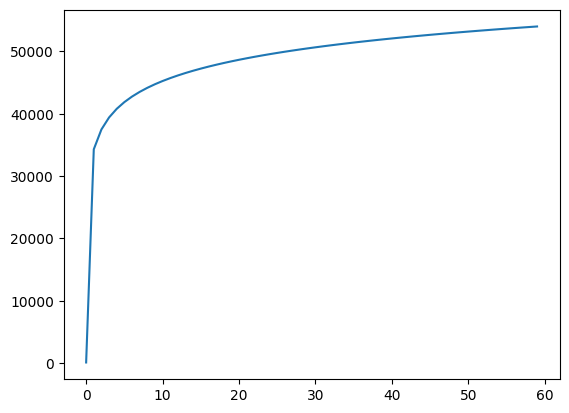

In [8]:
usm_fiat=UserGrowth_Spaced(100,54000,ITERATIONS,log_saturated_space)


ap_fiat=AgentPool_Basic(users_controller=usm_fiat,transactions_controller=1000,currency='$')
plt.plot(usm_fiat._num_users_store)

100%|██████████████████████████████████████████| 50/50 [00:00<00:00, 614.45it/s]


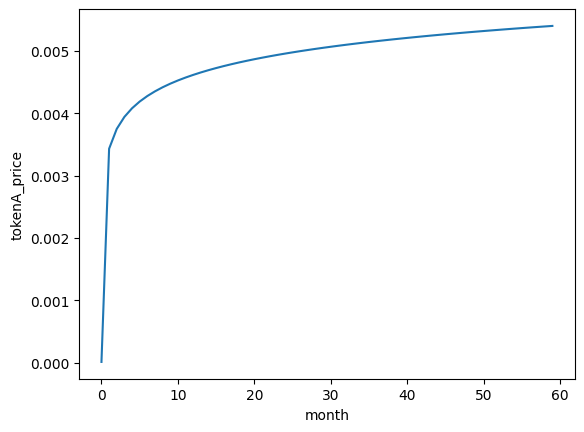

In [9]:
te=TokenEconomy_Basic(holding_time=HOLDING_TIME,supply=SUPPLY,token='tokenA',initial_price=INITIAL_PRICE)
te.add_agent_pools([ap_fiat])
meta=TokenMetaSimulator(te)
meta.execute(iterations=ITERATIONS,repetitions=50)
reps=meta.get_data()
plot,data=meta.get_timeseries('tokenA_price')
plot

# User growth and stochastic transactions

Now let's try to also include a stochastic component in transactions. For this purpose we will use the TransactionManagement_Stochastic class. This is one of the more complicate classes in TokenLab. The class works as follows:

1. You can define the activity_probs which determine the % of users which are active at any given time. This % is sampled from a binomial distribution.

2. You can define a distribution for the average value of the transaction per iteration. This can be any distribution with location and scale parameters from scipy.stats. By default, the distribution is the Gaussian. In this example we've set the average value to be 1000, and the standard deviation to be 200.

3. You can define the number of transactions per active user. By default, this is done through a Poisson distribution. In this example, we define the parameter mu=1.

You will see that now the price fluctuates more wildly as transactions are stochastic. However, because the activity probabilities rise over time (users become more active), the expected average price per month follows a rising trend.

In [10]:
usm_fiat=UserGrowth_Spaced(100,54000,ITERATIONS,log_saturated_space)
tsm_fiat=TransactionManagement_Stochastic(activity_probs=np.linspace(0.25,1,ITERATIONS),
                                            value_dist_parameters={'loc':1000,'scale':200},
                                           transactions_dist_parameters={'mu':1})

ap_fiat=AgentPool_Basic(users_controller=usm_fiat,transactions_controller=tsm_fiat,currency='$')

100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 30.22it/s]


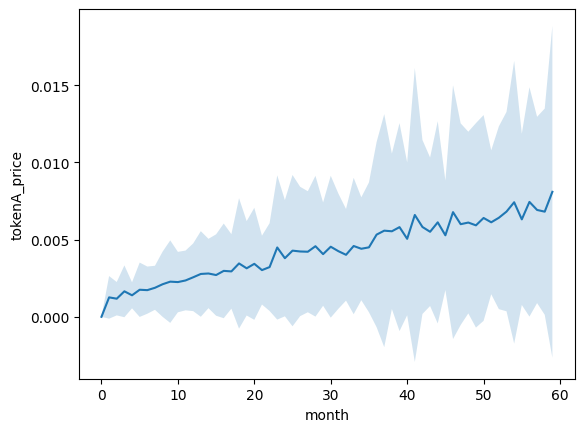

In [11]:
te=TokenEconomy_Basic(holding_time=HOLDING_TIME,supply=SUPPLY,token='tokenA',initial_price=INITIAL_PRICE)
te.add_agent_pools([ap_fiat])
meta=TokenMetaSimulator(te)
meta.execute(iterations=ITERATIONS,repetitions=50)
reps=meta.get_data()
plot,data=meta.get_timeseries('tokenA_price')
plot

# Stochastic holding time

Now, let's experiment with changing the holding time. The HoldingTime_Stochastic class is using a standard normal distribution to simulate different holding times.

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 23.66it/s]


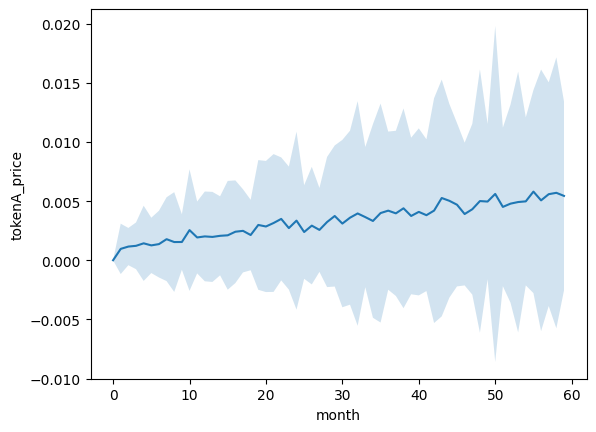

In [12]:
te=TokenEconomy_Basic(holding_time=HoldingTime_Stochastic(),supply=SUPPLY,token='tokenA',initial_price=INITIAL_PRICE)
te.add_agent_pools([ap_fiat])
meta=TokenMetaSimulator(te)
meta.execute(iterations=ITERATIONS,repetitions=50)
reps=meta.get_data()
plot,data=meta.get_timeseries('tokenA_price')
plot

# Price plus noise

There are different pricing functions that we can use. Let's try replacing the normal pricing function, with one that adds Gaussian noise and let's see what happens.

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 17.73it/s]


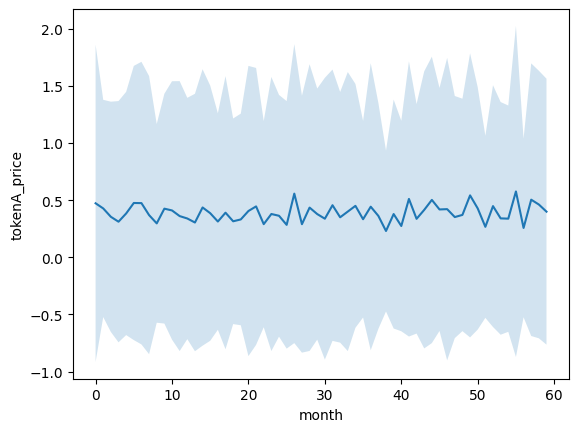

,tokenA_price,transactions_$,num_users,iteration,holding_time,effective_holding_time,supply,transactions_tokenA,repetition_run,iteration_time
0,0.525749,2.199834e+04,100,1,0.716324,258.766322,10000000000,1.575793e+05,0,0
1,0.291033,1.773603e+07,34399,2,0.643808,258.766322,10000000000,2.171873e+07,0,1
2,0.000270,1.025201e+07,71882,3,0.263744,258.766322,10000000000,9.290709e+06,0,2
3,0.000553,2.296978e+07,111288,4,0.240569,258.766322,10000000000,2.043639e+10,0,3
4,0.000261,1.227799e+07,152076,5,0.212564,258.766322,10000000000,4.723048e+09,0,4
...,...,...,...,...,...,...,...,...,...,...
55,0.006918,5.089789e+07,2694838,56,1.359213,4.785543,10000000000,1.089172e+11,49,55
56,0.001371,5.169705e+07,2748580,57,0.265230,4.785543,10000000000,1.981989e+09,49,56
57,0.001240,5.241595e+07,2802409,58,0.236586,4.785543,10000000000,9.044052e+09,49,57
58,0.004683,5.326297e+07,2856324,59,1.068691,4.785543,10000000000,4.590138e+10,49,58


In [13]:
te=TokenEconomy_Basic(holding_time=HoldingTime_Stochastic(),supply=SUPPLY,
                      price_function=PriceFunction_EOE,token='tokenA',
                      price_function_parameters={'noise_addon':AddOn_RandomNoise()},initial_price=INITIAL_PRICE)
te.add_agent_pools([ap_fiat])
meta=TokenMetaSimulator(te)
meta.execute(iterations=ITERATIONS,repetitions=50)
reps=meta.get_data()
plot,data=meta.get_timeseries('tokenA_price')
plot
reps

# Price plus noise plus adaptive variance

This is a special pricing mechanism which induces randomness in the price, but the variance of the noise is proportional to the price. The idea behind this is similar to https://www.investopedia.com/terms/g/garch.asp and has also been observed in the cryptocurrency markets. For example, this holds true for Bitcoin. The higher the value of bitcoin, the higher the observed volatility.

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 18.10it/s]


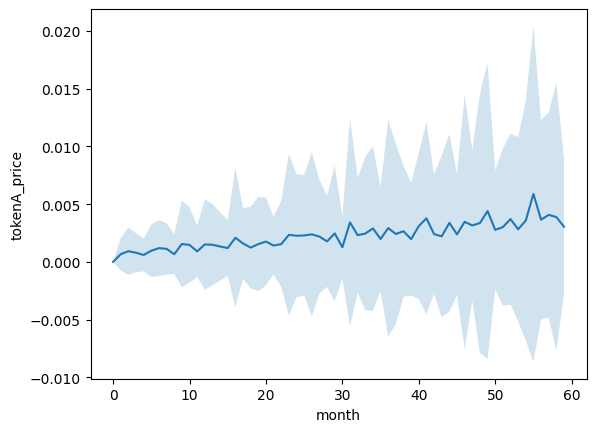

In [14]:
te=TokenEconomy_Basic(holding_time=HoldingTime_Stochastic(),supply=SUPPLY,
                      price_function=PriceFunction_EOE,token='tokenA',
                      price_function_parameters={'noise_addon':AddOn_RandomNoiseProportional(std_param=3)},initial_price=INITIAL_PRICE)

te.add_agent_pools([ap_fiat])
meta=TokenMetaSimulator(te)
meta.execute(iterations=ITERATIONS,repetitions=50)
reps=meta.get_data()
plot,data=meta.get_timeseries('tokenA_price')
plot

In [15]:
reps

,tokenA_price,transactions_$,num_users,iteration,holding_time,effective_holding_time,supply,transactions_tokenA,repetition_run,iteration_time
0,1.619273e-07,2.902197e+04,100,1,0.482813,0.484233,10000000000,1.401217e+05,0,0
1,6.497572e-04,8.926995e+06,34399,2,0.727857,0.484233,10000000000,4.012647e+13,0,1
2,6.589594e-05,1.026370e+07,71882,3,1.022224,0.484233,10000000000,1.614725e+10,0,2
3,1.672769e-03,1.127134e+07,111288,4,1.484091,0.484233,10000000000,2.538500e+11,0,3
4,2.211051e-04,1.218187e+07,152076,5,0.512167,0.484233,10000000000,3.729833e+09,0,4
...,...,...,...,...,...,...,...,...,...,...
55,5.672023e-03,1.527932e+08,2694838,56,0.371222,0.342536,10000000000,6.955520e+09,49,55
56,2.420357e-03,1.549142e+08,2748580,57,0.388000,0.342536,10000000000,1.059704e+10,49,56
57,8.267080e-04,1.573562e+08,2802409,58,0.498831,0.342536,10000000000,3.243085e+10,49,57
58,5.950568e-04,5.324282e+07,2856324,59,0.185920,0.342536,10000000000,1.197387e+10,49,58
